<a href="https://colab.research.google.com/github/saadhassan99/cse455-FinalProject/blob/main/CSE455_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Dataset from kaggle

In [54]:
# install kaggle
!pip install -q kaggle

In [55]:
# import the kaggle api key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"besaad","key":"d44f871b37788706cfa7d816f06c9757"}'}

In [56]:
# create a kaggle folder
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# copy the kaggle.json to the folder created
!cp kaggle.json ~/.kaggle/

In [59]:
# permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [60]:
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [61]:
# download the humpback whale identification dataset from kaggle
!kaggle competitions download -c humpback-whale-identification

humpback-whale-identification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [65]:
!unzip humpback-whale-identification.zip

Archive:  humpback-whale-identification.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N
N
A


# Import Libraries

In [63]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd

import time
import json
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


# Visualize/Analyse the data

In [67]:
train_labels = pd.read_csv('/content/train.csv')
train_labels.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [68]:
num_classes = len(train_labels['Id'].unique())
print(num_classes)

5005


I appears that we have 5005 unique whale species in our dataset

Lets visualize the frequency of each class by plotting the number of different species on a histogram

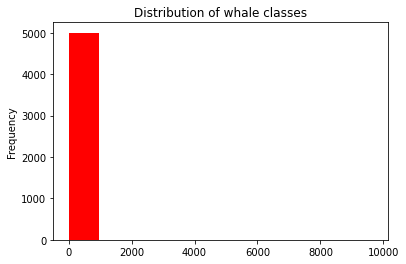

In [14]:
plt.title('Distribution of whale classes')
train_labels.Id.value_counts().plot(kind='hist', color='r')

from the graph above, we see that one of the classes completely overwhelms the other classes. the data is extremely skewed. lets find out which one of the classes is that.

In [15]:
train_labels.Id.value_counts().head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

it is the new_whales class with high amount of samples. due to the high number of samples in this class, our classifier, might only learn to classify just this class and perform poorly on classifying other classes.

lets see what the rest of the classes look like by plotting the data without the new_whales class.

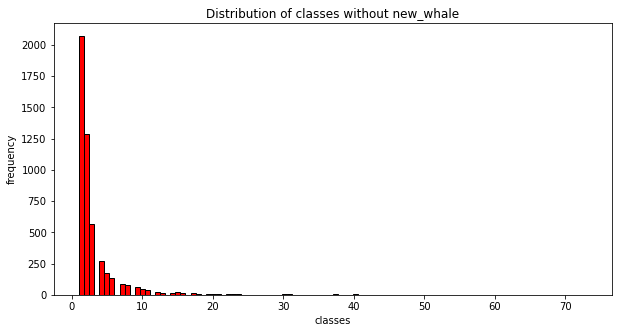

In [16]:
plt.figure(figsize=(10,5))
plt.hist(train_labels.Id.value_counts()[1:], bins=100, color='r', edgecolor='black')
plt.ylabel('frequency')
plt.xlabel('classes')
plt.title('Distribution of classes without new_whale')
plt.show()

We can see that there is a great disbalance in the distribution of the samples. Some classes have as little as only 1 sample image. while others have almost 10,000. A simple CNN from scratch is going to perform horribly. As we will soon see too. Our best option in case is to either find more data or use a pretrained network. Finding more data will be expensive and time consuming, so i will go with the latter option and see how it goes.

In [17]:
print(f"There are {len(os.listdir('/content/train'))} images in train dataset with {train_labels.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('/content/test'))} images in test dataset.")

There are 25361 images in train dataset with 5005 unique classes.
There are 7960 images in test dataset.


Now, lets looking at some sample images to have a sense of what kind of images we are working with

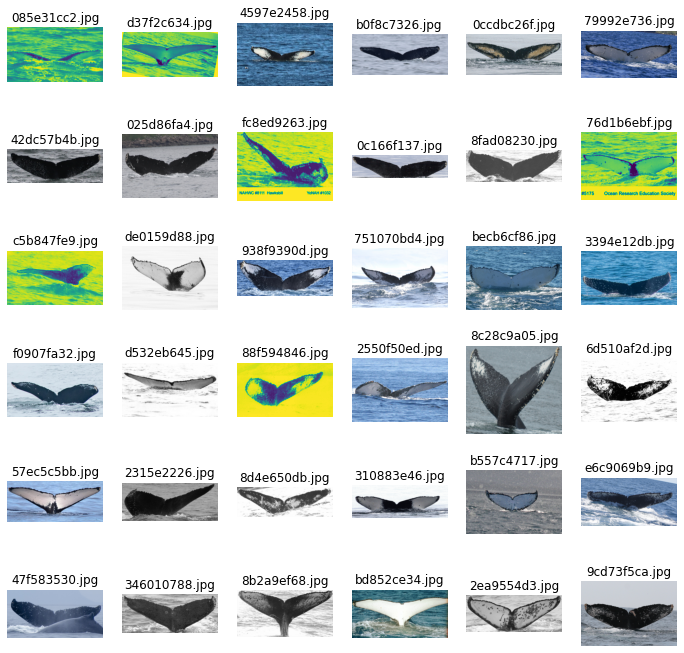

In [18]:
w = 6
h = 6

load_img = lambda filename: np.array(Image.open(f"/content/train/{filename}"))

_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h))

train_imgs = os.listdir("/content/train")

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        img = np.random.choice(train_imgs)
        ax.imshow(load_img(img))
        ax.set_title(img)

I noticed that the images are not the same size and color. We got colored and black and white images. Neural networks do not work very well with images of different sizes. Before proceeding to create training models, we need to do some Image preprocessing to prepare the images to feed in the neural networks. 

# Image Preprocessing

we will apply the following transformations to our images

In [13]:
transform = transforms.Compose([transforms.Resize((100, 100)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])

In [69]:
# one-hot encode the labels
def one_hot(labels):
    values = np.array(labels)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded, label_encoder

In [70]:
train_y, le = one_hot(train_labels['Id'])

In [71]:
train_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [72]:
class PrepareDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None,
                 transform=transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        
        if self.datatype == 'train':
            self.df = df.values
        
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, index):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[index][0])
            label = self.y[index]
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[index])
            label = np.zeros((5005,))
        
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)

        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            return image, label, self.image_files_list[index]

In [18]:
train_x = PrepareDataset(datafolder='/content/train/', 
                         datatype='train',
                         df=train_labels,
                         transform=transform,
                         y=train_y)

In [19]:
test_x = PrepareDataset(datafolder='/content/test/',
                        datatype='test',
                        transform=transform)

In [20]:
# define batch size and data loaders
batch_size = 512
test_size = 32
num_workers = 0

# we will shuffle the datasets
train_sampler = SubsetRandomSampler(list(range(len(os.listdir('/content/train')))))
test_sampler = SubsetRandomSampler(list(range(len(os.listdir('/content/test')))))

train_loader = torch.utils.data.DataLoader(train_x, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_x, batch_size=test_size, num_workers=num_workers)

# Model 1: Basic CNN

It is now time to start building our first CNN model. For this one, i will start from scratch and although i do not expect to perform very well given the nature of our dataset, i am still curious to see how it will perform.

In [ ]:
from torch.nn.modules.linear import Linear
from torch.nn.modules.activation import ReLU
from torch.nn.modules.pooling import MaxPool2d, AvgPool2d
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.container import Sequential


class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.cnn_layers = Sequential(
            # first layer
            Conv2d(in_channels=3, out_channels=32, kernel_size=7, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(2, 2),

            # second layer
            Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            BatchNorm2d(64),
            ReLU(inplace=True),
            AvgPool2d(3, 3),
        )

        self.linear_layers = Sequential(
            Linear(64 * 4 * 4 * 16, 1024),
            Linear(1024, 5005)
        )

        self.dropout = nn.Dropout(0.5)        

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 64 * 4 * 4 * 16)
        x = self.dropout(x)
        x = self.linear_layers(x)

        return x

In [ ]:
from torch.nn.modules.loss import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR

# defining the model
model1 = BasicCNN()

# defining the optimizer
optimizer = optim.Adam(model1.parameters(), lr=0.07)
exp_lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# defining the loss function
criterion = CrossEntropyLoss()

if torch.cuda.is_available():
    model1 = model1.cuda()
    criterion = criterion.cuda()

print(model1)

BasicCNN(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=3, stride=3, padding=0)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=16384, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=5005, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


This is the architecture to train our model. We have two Conv2d layers and two linear layers. Next, we will train the model.

## Model1: Training

In [ ]:
# we will train our model for 10 epochs
n_epochs = 10

train_losses = []

for epoch in range(n_epochs):
    print(time.ctime(), 'Epoch:', epoch)

    exp_lr_scheduler.step()

    for batch_i, (train_X, train_y) in enumerate(train_loader):
        if torch.cuda.is_available():
            train_X = train_X.cuda() 
            train_y = train_y.cuda()

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        # prediction for training set
        output = model1(train_X)

        # computing the training loss
        loss = criterion(output, train_y.float())
        train_losses.append(loss.item())

        # computing the updated weights of all the model parameters
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch}, train loss: {np.mean(train_losses):.4f}')

Thu Mar 10 06:35:36 2022 Epoch: 0
Epoch 0, train loss: 6.0379
Thu Mar 10 06:41:31 2022 Epoch: 1
Epoch 1, train loss: 5.9999
Thu Mar 10 06:47:25 2022 Epoch: 2
Epoch 2, train loss: 5.9791
Thu Mar 10 06:52:38 2022 Epoch: 3
Epoch 3, train loss: 5.9646
Thu Mar 10 06:57:44 2022 Epoch: 4
Epoch 4, train loss: 5.9536
Thu Mar 10 07:02:51 2022 Epoch: 5
Epoch 5, train loss: 5.9456
Thu Mar 10 07:08:01 2022 Epoch: 6
Epoch 6, train loss: 5.9418
Thu Mar 10 07:13:09 2022 Epoch: 7
Epoch 7, train loss: 5.9381
Thu Mar 10 07:18:22 2022 Epoch: 8
Epoch 8, train loss: 5.9346
Thu Mar 10 07:23:32 2022 Epoch: 9
Epoch 9, train loss: 5.9323


## Model1: Result

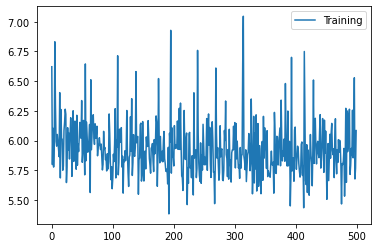

In [ ]:
# plotting the training loss
plt.plot(train_losses, label='Training')
plt.legend()
plt.show()

As expected, our simple model, performed terribly. It never learned anything.

# Image Preprocessing

Our initial dataset is quiet small. so its very possible that this lack of data was also a contributing factor in the poor performance of the Simple CNN. So before i go ahead and train on a pretrained network. i will do some data augmentation. Therefor, i will do image preprocessing a second time.

In [23]:
from torchvision.transforms.transforms import RandomRotation

transform_train = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomRotation(25),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(degrees=4),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

In [24]:
# apply the transformations to our dataset
train_X2 = PrepareDataset(datafolder='/content/train/', 
                          datatype='train',
                          df=train_labels,
                          transform=transform_train,
                          y=train_y)

In [25]:
test_X2 = PrepareDataset(datafolder='/content/test/',
                         datatype='test',
                         transform=transform_test)

In [26]:
# define batch size and data loaders
batch_size = 10
test_size = 10
num_workers = 2

# we will shuffle the datasets
train_sampler = SubsetRandomSampler(list(range(len(os.listdir('/content/train')))))
test_sampler = SubsetRandomSampler(list(range(len(os.listdir('/content/test')))))

train_loader = torch.utils.data.DataLoader(train_X2, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_X2, batch_size=test_size, num_workers=num_workers)

In [27]:
# confirm tensor sizes
dataiter = iter(train_loader)
images, labels = dataiter.next()

print("Batch shape: ", images.size())

Batch shape:  torch.Size([10, 3, 224, 224])


# Model 2: Pretrained Resnet152

In [28]:
model2_resnet = models.resnet152(pretrained=True)

# freeze the parameters
for param in model2_resnet.parameters():
    param.requires_grad = False

print(model2_resnet)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
from torch.nn.modules.dropout import Dropout
final_layer = nn.Sequential(nn.Linear(2048, 1024),
                            nn.ReLU(),
                            Dropout(0.1),
                            nn.Linear(1024, 5005))
model2_resnet.fc = final_layer

In [30]:
print(model2_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
from torch.nn.modules import BCEWithLogitsLoss
from torch.optim.lr_scheduler import StepLR
from torch.optim.adam import Adam

# define the optimizer
optimizer = Adam(model2_resnet.fc.parameters(), lr=0.001)
schedular = StepLR(optimizer, step_size=3, gamma=0.1)

# define the loss function
criterion = BCEWithLogitsLoss()

if torch.cuda.is_available():
    model2_resnet = model2_resnet.cuda()
    criterion = criterion.cuda()

## Model2: Training

In [33]:
# we will train our model for 10 epochs
n_epochs = 10

train_losses = []

for epoch in range(n_epochs):
    print(time.ctime(), 'Epoch:', epoch)

    for batch_i, (train_X2, train_y) in enumerate(train_loader):

        if torch.cuda.is_available():
            train_X2 = train_X2.cuda() 
            train_y = train_y.cuda()
            
        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        # prediction for training set
        output = model2_resnet(train_X2)

        # computing the training loss
        loss = criterion(output, train_y.float())
        train_losses.append(loss.item())

        # computing the updated weights of all the model parameters
        loss.backward()
        optimizer.step()
    
    schedular.step()

    print(f'Epoch {epoch}, train loss: {np.mean(train_losses):.4f}')

Fri Mar 11 06:57:50 2022 Epoch: 0
Epoch 0, train loss: 0.0017
Fri Mar 11 07:07:47 2022 Epoch: 1
Epoch 1, train loss: 0.0016
Fri Mar 11 07:17:19 2022 Epoch: 2
Epoch 2, train loss: 0.0015
Fri Mar 11 07:26:49 2022 Epoch: 3
Epoch 3, train loss: 0.0015
Fri Mar 11 07:36:19 2022 Epoch: 4
Epoch 4, train loss: 0.0014
Fri Mar 11 07:46:02 2022 Epoch: 5
Epoch 5, train loss: 0.0014
Fri Mar 11 07:55:44 2022 Epoch: 6
Epoch 6, train loss: 0.0014
Fri Mar 11 08:05:14 2022 Epoch: 7
Epoch 7, train loss: 0.0013
Fri Mar 11 08:14:45 2022 Epoch: 8
Epoch 8, train loss: 0.0013
Fri Mar 11 08:24:15 2022 Epoch: 9
Epoch 9, train loss: 0.0013


In [35]:
# save the trained model
torch.save(model2_resnet.state_dict(), '/content/model2.pt')

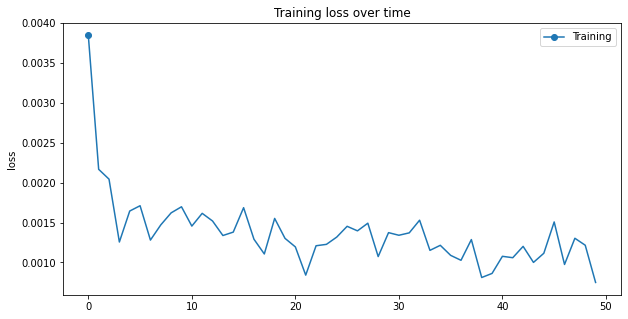

In [45]:
# plotting the training loss
plt.figure(figsize=(10,5))
plt.plot(train_losses[::512], label='Training', marker='o', markevery=500)
plt.ylabel('loss')
plt.title('Training loss over time')
plt.legend()
plt.show()

In [50]:
sub = pd.read_csv('/content/sample_submission.csv')

model2_resnet.eval()
for (data, target, name) in test_loader:
    data = data.cuda()
    output = model2_resnet(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv('submission.csv', index=False)

## Model2: Result

Although the model performed well on the training data, Submitting the test predictions to kaggle generated a score of: 0.29598. This is an indication that our model is over fitting on the training data. I believe we can do better than this. So i will train one more Model. with some additional hyperparameter tuning.

# Image Preprocessing

In [73]:
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomAffine(30),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

In [74]:
# apply the transformations to our dataset
train_X3 = PrepareDataset(datafolder='/content/train/', 
                          datatype='train',
                          df=train_labels,
                          transform=transform_train,
                          y=train_y)

In [75]:
test_X3 = PrepareDataset(datafolder='/content/test/',
                         datatype='test',
                         transform=transform_test)

In [76]:
# define batch size and data loaders
batch_size = 32
test_size = 32
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_X3, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_X3, batch_size=test_size, num_workers=num_workers)

In [77]:
# confirm tensor sizes
dataiter = iter(train_loader)
images, labels = dataiter.next()

print("Batch shape: ", images.size())

Batch shape:  torch.Size([32, 3, 224, 224])


# Model 3: Pretrained DenseNet

In [78]:
model3_densenet = models.densenet121(pretrained=True)

# freeze the parameters
for param in model3_densenet.parameters():
    param.requires_grad = False

num_ftrs = model3_densenet.classifier.in_features
model3_densenet.classifier = nn.Linear(num_ftrs, 5005)

In [79]:
num_ftrs

1024

In [80]:
print(model3_densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [81]:
from torch.nn.modules import BCEWithLogitsLoss
from torch.optim.lr_scheduler import StepLR
from torch.optim.adam import Adam

# define the optimizer
optimizer = Adam(model3_densenet.parameters(), lr=0.0001)

# define the loss function
criterion = BCEWithLogitsLoss()

if torch.cuda.is_available():
    model3_densenet.cuda()
    nn.DataParallel(model3_densenet)
    criterion = criterion.cuda()
    print("Training on GPU!")

## Model3: Training

In [ ]:
# we will train our model for 10 epochs
n_epochs = 10

train_losses = []

for epoch in tqdm(range(n_epochs)):
    print(time.ctime(), 'Epoch:', epoch)

    for batch_i, (train_X3, train_y) in enumerate(train_loader):

        if torch.cuda.is_available():
            train_X3 = train_X3.cuda() 
            train_y = train_y.cuda()
            
        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        # prediction for training set
        output = model3_densenet(train_X3)

        # computing the training loss
        loss = criterion(output, train_y.float())
        train_losses.append(loss.item())

        # computing the updated weights of all the model parameters
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch}, train loss: {np.mean(train_losses):.4f}')

In [26]:
# save the trained model
torch.save(model3_densenet.state_dict(), '/content/model3.pt')

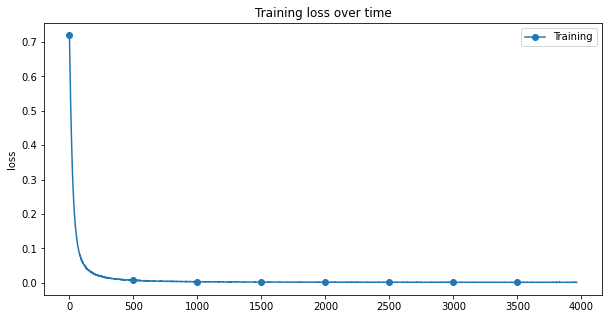

In [28]:
# plotting the training loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training', marker='o')
plt.ylabel('loss')
plt.title('Training loss over time')
plt.legend()
plt.show()

In [29]:
sub = pd.read_csv('/content/sample_submission.csv')

model3_densenet.eval()
for (data, target, name) in test_loader:
    data = data.cuda()
    output = model3_densenet(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv('submission_model2.csv', index=False)